# Spatial Baseline

The main goal is to collect data and derive a baseline concentration from CAMS pixels over the same period that the fire event took place. CAMS pixels are selected using a [Nearest Neighbors (NN)](https://scikit-learn.org/stable/modules/neighbors.html) search, based on similarity in physical characteristics such as elevation, slope and land cover and meteorological conditions, such as wind speed, wind direction, precipitation and temperature.    

### Data for NN search 

#### Land Cover

The 2018 CORINE Land cover map was used to determine the most common land cover type for the area of each CAMS pixel. 

#### Slope & Elevation

Using the EU-DEM v1.1 the mean, median, first and third quartile elevation and slope were calculated for each CAMS
pixel.

All the info on the physical characteristics per CAMS pixel were stored in the database table "spatial_baseline_info"

#### Meteorological Data

Based on the time and location of the fire event, the meteorological characteristics for the NN search are derived from the MERA or ERA5 dataset. The MERA dataset covers the period between 2015 and August 2019, and the ERA5 is used for any fire event after August 2019. 

For each CAMS pixel the following statistics are calculated: 
 
* Temperature: Mean, Standard Deviation, first and third quartile 
* Total Precipitation: Mean, Standard Deviation, first and third quartile
* Wind Speed: Mean, Standard Deviation, first and third quartile
* Wind Direction: Mean

### Calculating the baseline

You can specify some conditions for the NN search, such as the number of neighbours/pixels to use for the baseline, the minimum and maximum distance from the location of the fire event to search for the pixels and whether you want to exclude CAMS pixels over the ocean. I've also been working on labelling pixels based on if they are upwind or downwind from the fire event, so you can choose to filter pixels based on this label, but it is still a bit buggy/unreliable.

Based on the coordinates and timestamp of the fire event and the search conditions specified, the data for the NN search is generated and combined. Next, the data is normalised and an NN search is performed, returning the pixel information of the pixels most similar to the target pixel (the pixel closest to the fire event).

The pollutant concentrations are selected from the CAMS dataset for each of the pixels from the NN result and the mean, median, standard deviation, lower quartile and the upper quartile are calculated for this collection. These statistics indicate the baseline concentration range.

In [1]:
import os, sys

# adds the package path to the Python path to make sure all the local imports work fine 
if os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))) not in sys.path:
    sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

# local imports
from wp4.constants import POLLUTANTS, DATA_DIR_CAMS, DATA_DIR_PLOTS, DB_HOST, DB_NAME, DB_USER, DB_PASS
from wp4.baseline.spatial import get_spatial_baseline

# import remaining packages needed for the script
import xarray as xr
import pandas as pd
import psycopg2
from pathlib import Path
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

## Initiate connection and load fire events from the Postgres database

In [2]:
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST)
cur = conn.cursor()

query = """
    SELECT id, datetime, ST_X(geometry), ST_Y(geometry), source, location, reference, type, info, frp
    FROM public.all_fire_events
    WHERE reference = 'Aqua' OR reference = 'Terra' AND "frp" > 50 AND "frp" IS NOT NULL
"""

df_fire_events = pd.read_sql_query(query,con=conn).rename(columns = {'st_x':'longitude', 'st_y':'latitude'})

conn.close()

In [3]:
def create_plot(df_baseline, name_pollutant):
    """
    Creates a plot of the spatial baseline concentration range and the pollutant concentration 
    at the location of the Fire event itself
    """
    
    fig = go.Figure()  # init a plotly figure

    # Update xaxis properties
    fig.update_xaxes(title_text="Date")
    
    # Update yaxis properties
    fig.update_yaxes(title_text=f"{name_pollutant} Concentration µg m<sup>{{-3}}</sup>")
    
    fig.update_layout(
        template=pio.templates["seaborn"],
        autosize=False,
        width=1000,
        height=500
    )  
    
    fig.update_layout(legend=dict(  # position the legend
        yanchor="top",
        y=-0.2,
        xanchor="left",
        x=0.01)
    )
    
    colors = {
        'Q1':"#29bf12",
        'Q3':"#29bf12",
        'MED':"#48cae4",
        'FE':"#f21b3f"
    }
                      
    fig.add_trace(go.Scatter(  # add the baseline values
                x=df_baseline['time'],
                y=df_baseline['spatial_baseline_lower_quartile'].rolling(window=3, min_periods=1).mean(),
                mode='lines',
                name='25th percentile',
                line={'color': colors['Q1']}),
            )
            
    fig.add_trace(go.Scatter(  # add the baseline values
                x=df_baseline['time'],
                y=df_baseline['spatial_baseline_upper_quartile'].rolling(window=3, min_periods=1).mean(),
                fill='tonexty', # fill area between trace0 and trace1
                mode='lines',
                name='75th percentile',
                line={'color': colors['Q3']}),
            )
            
    fig.add_trace(go.Scatter(  # add the baseline values
                x=df_baseline['time'],
                y=df_baseline['spatial_baseline_median'].rolling(window=3, min_periods=1).mean(),
                mode='lines',
                name='Median',
                line={'color': colors['MED']}),
            )
    
    fig.add_trace(go.Scatter(  # add the CAMS analysis concentration data closest to the fireevent
                x=df_baseline['time'],
                y=df_baseline['fire_event'].rolling(window=3, min_periods=1).mean(),
                mode='lines',
                name='CAMS Regional Analysis cell closest to fire event',
                line={'color': colors['FE']}),
            )
    
    return fig

def create_nn_map(ds, df_nn, df_fe_information, name_pollutant, title):
    """Maps the location of the fire event and the nearest neighbours to a map"""
    ds = ds.mean(dim='time')
    ds['longitude'] = ds['longitude'].values - 360 
    
    fig, ax = plt.subplots(figsize=(13, 13))
    ax = plt.axes(projection=ccrs.Orthographic(8.7, 49.9))
    ax.coastlines(lw=1.5)
    
    ds[name_pollutant].plot(
                transform=ccrs.PlateCarree(),
                robust=True,
                extend='neither',
                cmap='GnBu',
                facecolor="gray",
            )
    
    ax.scatter(
        df_nn['longitude'].values,
        df_nn['latitude'].values,
        transform=ccrs.PlateCarree(),
        marker="o",
        label='baseline pixel',
        c='orange',
        zorder=2,
        s=50,
        alpha=1)
    
    sc = ax.scatter(
        df_fe_information['longitude'].iloc[0],
        df_fe_information['latitude'].iloc[0],
        transform=ccrs.PlateCarree(),
        marker="X",
        label='fire event',
        c='red',
        zorder=3,
        s=50,
        alpha=1)
    
    ax.legend(loc='upper left', fontsize=12)
    ax.set_title(title)
    plt.show()
    
    return fig

## Calculate spatial baseline, plot it along with the pollutant concentration during the fire event. 

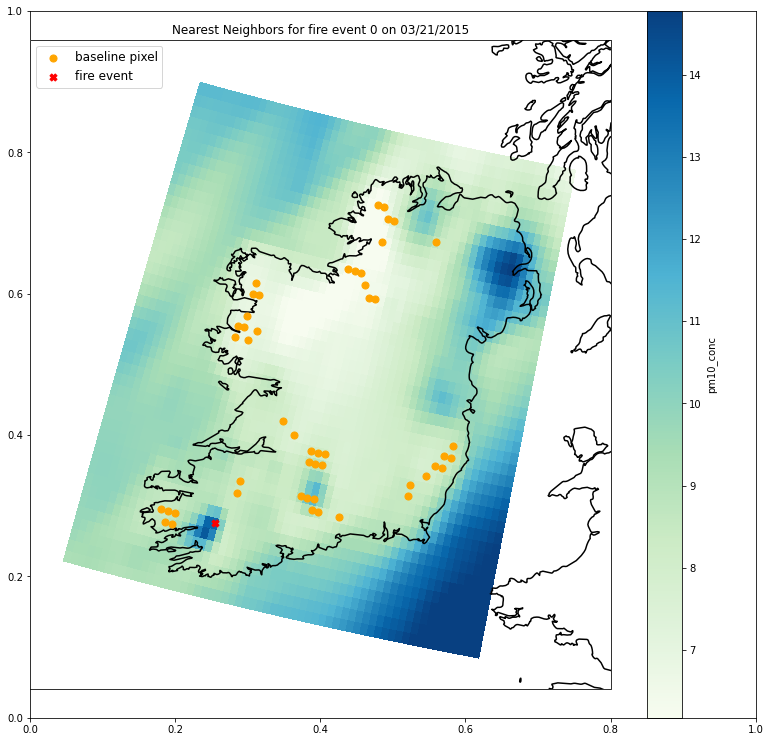

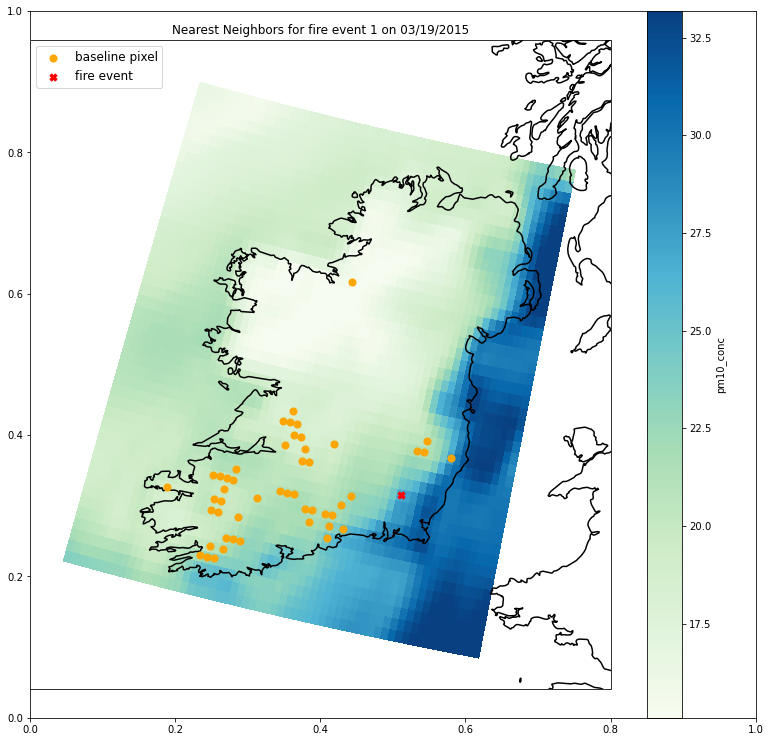

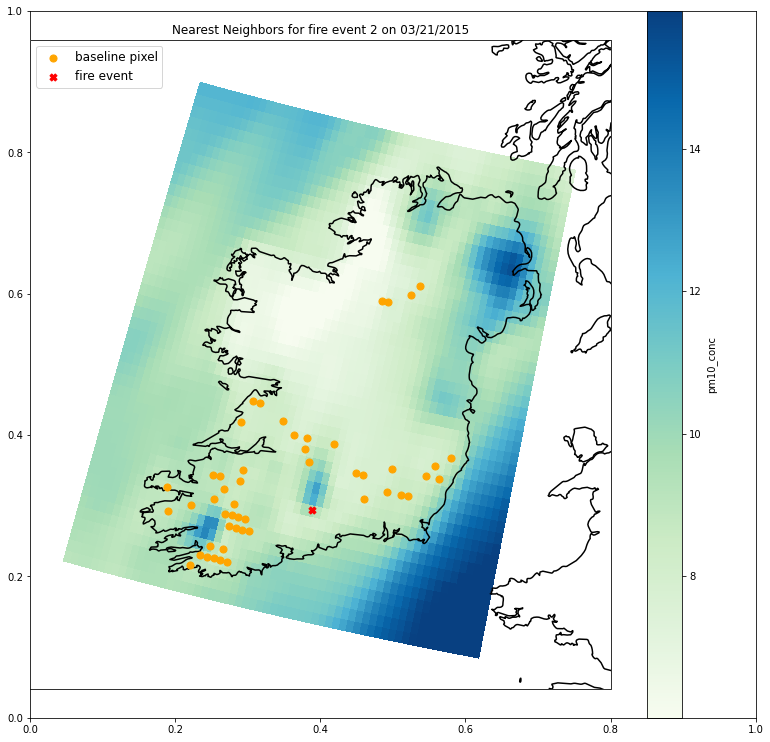

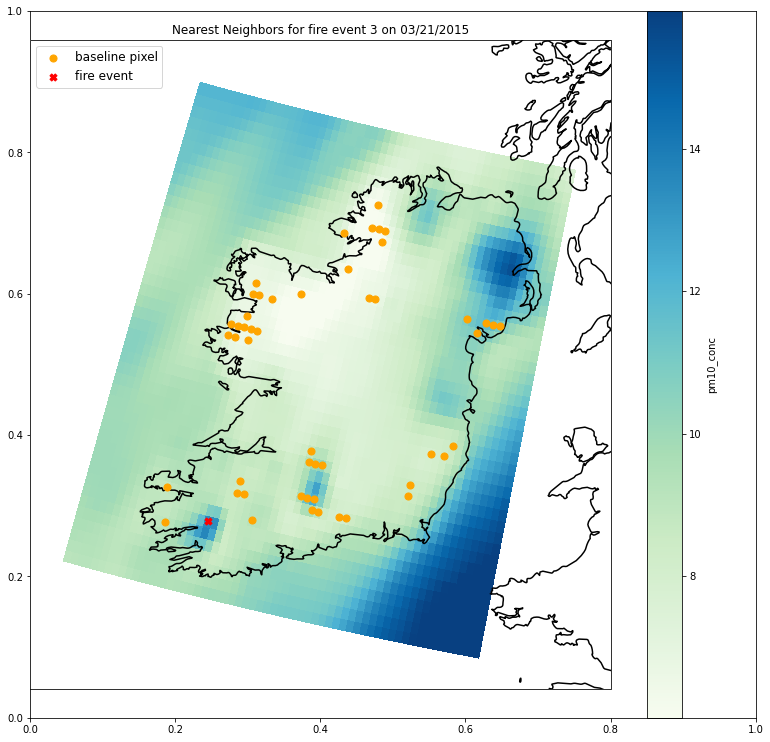

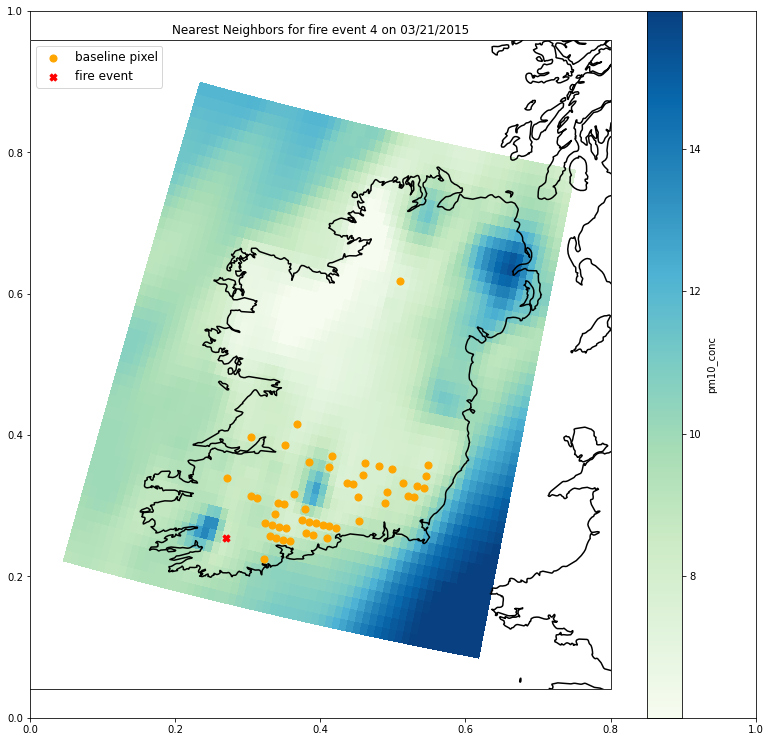

KeyboardInterrupt: 

In [4]:
pollutant = 'PM10'  # 'CO', 'O3', 'NO', 'NO2', 'PM25', 'PM10', 'SO2'
name_pollutant = POLLUTANTS[pollutant]['FULL_NAME']
name_pollutant_var = POLLUTANTS[pollutant]['CAMS']

for ind, fe in df_fire_events[0:50].iterrows():
    
    try:
        # df_baseline: pandas dataframe containing all the baseline information,
        # ds_fe: xArray dataset containing all the feature information generated from the meteo data for the NN search,
        # df_nn: pandas dataframe containing the result from the NN search and all the information for each match,
        # df_fe_information: pandas dataframe containing all the information of the target pixel of the NN search
        
        df_baseline, ds_fe, df_nn, df_fe_information = get_spatial_baseline(
            fe_lat=fe['latitude'],
            fe_long=fe['longitude'],
            timestamp=fe['datetime'],
            days=5, # time window around fire event
            pollutant=pollutant,
            meteo_dataset='MERA',
            min_distance_km=40,
            max_distance_km=350,
            number_of_neighbours=50,
#             upwind_downwind='upwind',
            mask_ocean=True,          
        )

        plot = create_plot(df_baseline, name_pollutant)
        
        plot.show()
        
        output_loc_fig = Path(DATA_DIR_PLOTS).joinpath('notebooks/spatial_baseline/plot/')
        
        if not os.path.exists(output_loc_fig):
            os.makedirs(output_loc_fig)

        plot.write_html(output_loc_fig.joinpath(f"fire_event_{ind}_{fe['datetime'].strftime('%m_%d_%Y')}.html"))
        
        map_title = f"Nearest Neighbors for fire event {ind} on {fe['datetime'].strftime('%m/%d/%Y')}"
        
        ds_fe = ds_fe.sel(time=slice(
                fe['datetime'].replace(minute=0),
                fe['datetime'].replace(minute=0) + timedelta(hours=18)
            ))
        
        fig = create_nn_map(ds_fe, df_nn, df_fe_information, name_pollutant_var, map_title)
        
        output_loc_map = Path(DATA_DIR_PLOTS).joinpath('notebooks/spatial_baseline/map/')
        
        if not os.path.exists(output_loc_map):
            os.makedirs(output_loc_map)    
        
        fig.savefig(output_loc_map.joinpath(f"fire_event_{ind}_{fe['datetime'].strftime('%m_%d_%Y')}.png"))
        
    except Exception as e:
        print(f'Skipping fire {ind} because of the following error: {e}')